In [1]:
import numpy as np
import pandas as pd
import math

## Part 1. Data Preprocessing

In [2]:
df = pd.read_csv('AAPL_max.csv')
df = df.iloc[-math.ceil(len(df) * 0.3):] # only use last 30% of data
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
6974,2008-08-04,22.371429,22.557142,21.844286,21.889999,18.950113,148131900.0
6975,2008-08-05,22.202858,22.971428,22.117144,22.948572,19.866512,172092900.0
6976,2008-08-06,22.852858,23.914286,22.571428,23.455715,20.305553,197852200.0


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df.dropna(inplace = True)

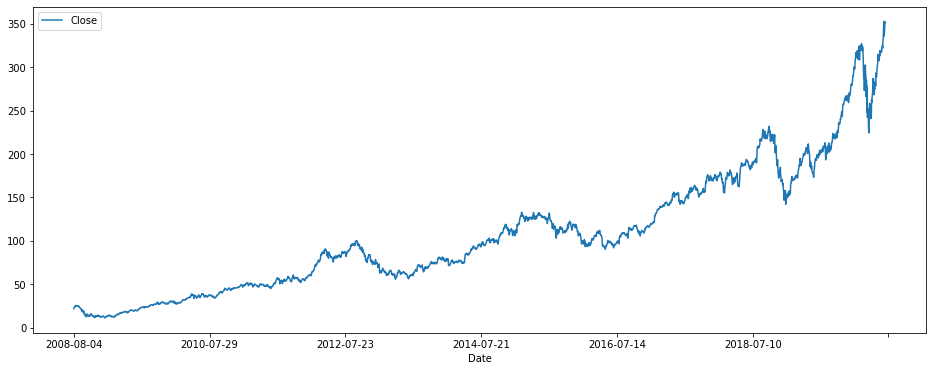

In [5]:
df.plot(x = 'Date', y = 'Close', figsize = (16, 6))

In [6]:
# use Close price for prediction
df = df[['Date', 'Close']]

In [7]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dataset = sc.fit_transform(pd.DataFrame(df.Close).values)

## Part 2. Training

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
                        
# parameters
lags = 3
test_size = 0.2
lstm_layers = 0
lstm_units = 128
dropout_prob = 1 
optimizer = 'nadam'
batch_size = 8
epochs = 50

# use lags of data as features
x, y = [], []
for i in range(lags, len(dataset)):
    x.append(dataset[i-lags:i])
    y.append(dataset[i])
x, y = np.array(x), np.array(y)

# split
train_size = len(x) - math.floor(len(x) * test_size)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

# reshape to add one dimension as lstm_1_input expects
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# init
rnn = Sequential()

# 1st LSTM layer
rnn.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (x_train.shape[1], 1)))
rnn.add(Dropout(dropout_prob))

for _ in range(0, lstm_layers):
    rnn.add(LSTM(units = lstm_units, return_sequences = True))
    rnn.add(Dropout(dropout_prob))

# last LSTM layer
rnn.add(LSTM(units = lstm_units))
rnn.add(Dropout(dropout_prob))

# output layer
rnn.add(Dense(units = 1))

# compile
rnn.compile(optimizer = optimizer, loss = 'mean_squared_error')

# predict
rnn.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)

# predict
y_pred = rnn.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)

# eval
rmse = math.sqrt(mean_squared_error(y_test, y_pred))


Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py


Epoch 1/50
2390/2390 [==============================] - 7s 3ms/step - loss: 0.0086
Epoch 2/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0019
Epoch 3/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0016
Epoch 4/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0014
Epoch 5/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0013
Epoch 6/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0011
Epoch 7/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0011
Epoch 8/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0011
Epoch 9/50
2390/2390 [==============================] - 5s 2ms/step - loss: 0.0013
Epoch 10/50
2390/2390 [==============================] - 6s 2ms/step - loss: 8.0779e-04
Epoch 11/50
2390/2390 [==============================] - 5s 2ms/step - loss: 7.5297e-04
Epoch 12/50
2390/2390 [==============================] - 5s 2ms/step - loss:

In [9]:
output_df = pd.DataFrame()
output_df['date'] = df.Date[train_size+lags:].values
output_df['actual'] = np.reshape(y_test, y_test.shape[0])
output_df['pred'] = np.reshape(y_pred, y_pred.shape[0])
output_df

,date,actual,pred
0,2018-02-05,156.490005,162.270660
1,2018-02-06,163.029999,159.848602
2,2018-02-07,159.539993,165.564926
3,2018-02-08,155.149994,160.020721
4,2018-02-09,156.410004,157.675156
...,...,...,...
592,2020-06-12,338.799988,304.110535
593,2020-06-15,342.989990,304.701935
594,2020-06-16,352.079987,304.172333
595,2020-06-17,351.589996,306.918762


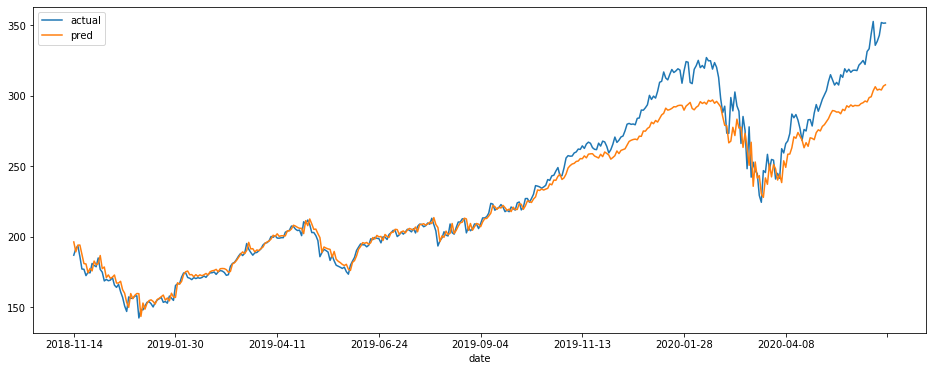

In [10]:
output_df_ex = output_df.iloc[-400:]
output_df_ex.reset_index(drop = True, inplace = True)
output_df_ex.plot(x = 'date', y = 'actual', figsize = (16, 6), legend = True)
output_df_ex.pred.plot(legend = True)